# Notebook 03 — Stress Propagation to Credit Portfolio

This notebook propagates macroeconomic stress scenarios defined in Notebook 02
through the baseline credit portfolio constructed in Notebook 01.

The objective is to quantify how portfolio-level losses amplify under
baseline, adverse, and severe macroeconomic conditions using transparent,
rule-based stress propagation.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.float_format", "{:.4f}".format)

In [3]:
# Portfolio baseline
df = pd.read_parquet("data/processed/portfolio_baseline.parquet")

# Macro scenario shocks
scenario_shocks = pd.read_csv(
    "data/processed/macro_scenarios_shocks.csv",
    index_col=0
)

In [4]:
df.head()

,loan_amnt,term,int_rate,grade,sub_grade,issue_d,loan_status,recoveries,purpose,home_ownership,vintage,is_default,exposure,loss
0,3600.0000,36,13.9900,C,C4,2015-12-01,fully paid,0.0000,debt_consolidation,MORTGAGE,2015,0,3600.0000,0.0000
1,24700.0000,36,11.9900,C,C1,2015-12-01,fully paid,0.0000,small_business,MORTGAGE,2015,0,24700.0000,0.0000
2,20000.0000,60,10.7800,B,B4,2015-12-01,fully paid,0.0000,home_improvement,MORTGAGE,2015,0,20000.0000,0.0000
3,35000.0000,60,14.8500,C,C5,2015-12-01,current,0.0000,debt_consolidation,MORTGAGE,2015,0,35000.0000,0.0000
4,10400.0000,60,22.4500,F,F1,2015-12-01,fully paid,0.0000,major_purchase,MORTGAGE,2015,0,10400.0000,0.0000


In [5]:
scenario_shocks

,unemployment_rate,fed_funds_rate,real_gdp,cpi,yield_spread
scenario,,,,,
baseline,1.0000,1.0000,1.0000,1.0000,1.0000
adverse,1.3236,2.1523,0.9800,1.0500,0.6217
severe,1.6472,3.3046,0.9500,1.1000,0.2433


In [6]:
baseline_loss = df["loss"].sum()
baseline_loss

np.float64(4219692182.4546375)

In [7]:
SENSITIVITY = {
    "unemployment_rate": 0.6,
    "fed_funds_rate": 0.2,
    "cpi": 0.2,
    "real_gdp": -0.4,      # GDP decline increases loss
    "yield_spread": -0.3  # Inversion increases stress
}

In [8]:
def compute_stress_multiplier(shocks, sensitivity):
    multiplier = 1.0
    for var, weight in sensitivity.items():
        multiplier *= shocks[var] ** weight
    return multiplier

In [9]:
scenario_results = []

for scenario in scenario_shocks.index:
    shock = scenario_shocks.loc[scenario]
    stress_multiplier = compute_stress_multiplier(shock, SENSITIVITY)

    stressed_loss = baseline_loss * stress_multiplier

    scenario_results.append({
        "scenario": scenario,
        "stress_multiplier": stress_multiplier,
        "stressed_loss": stressed_loss,
        "loss_increase_pct": (stressed_loss / baseline_loss - 1) * 100
    })

results = pd.DataFrame(scenario_results)
results

,scenario,stress_multiplier,stressed_loss,loss_increase_pct
0,baseline,1.0000,4219692182.4546,0.0000
1,adverse,1.6193,6832863049.7425,61.9280
2,severe,2.7241,11494771471.7935,172.4078


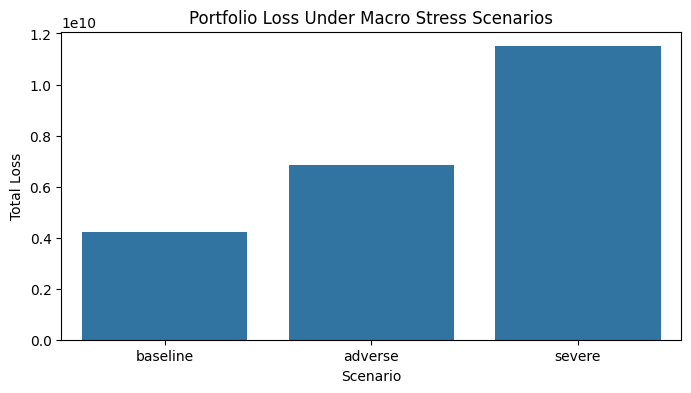

In [10]:
plt.figure(figsize=(8,4))
sns.barplot(
    x="scenario",
    y="stressed_loss",
    data=results
)
plt.title("Portfolio Loss Under Macro Stress Scenarios")
plt.ylabel("Total Loss")
plt.xlabel("Scenario")
plt.show()

In [11]:
grade_baseline = (
    df.groupby("grade")["loss"]
      .sum()
      .reset_index()
)

grade_stress = []

for scenario in scenario_shocks.index:
    shock = scenario_shocks.loc[scenario]
    stress_multiplier = compute_stress_multiplier(shock, SENSITIVITY)

    tmp = grade_baseline.copy()
    tmp["scenario"] = scenario
    tmp["stressed_loss"] = tmp["loss"] * stress_multiplier

    grade_stress.append(tmp)

grade_stress_df = pd.concat(grade_stress)
grade_stress_df.head()

,grade,loss,scenario,stressed_loss
0,A,204962708.5447,baseline,204962708.5447
1,B,741577938.0584,baseline,741577938.0584
2,C,1296589596.2155,baseline,1296589596.2155
3,D,981743660.7680,baseline,981743660.7680
4,E,635635597.7668,baseline,635635597.7668


The baseline scenario uses unit macro shocks, so the stress multiplier equals one by construction. This ensures that stressed losses match baseline losses under unstressed conditions, providing a clean reference point for evaluating amplification under adverse scenarios.

In [13]:
grade_stress_table = (
    grade_stress_df
    .pivot(index="grade", columns="scenario", values="stressed_loss")
    .reset_index()
)

grade_stress_table

scenario,grade,adverse,baseline,severe
0,A,331892009.4725,204962708.5447,558334445.5213
1,B,1200822304.6535,741577938.0584,2020116292.3563
2,C,2099541568.3397,1296589596.2155,3532011449.3595
3,D,1589717850.0064,981743660.7680,2674346501.2288
4,E,1029271994.5642,635635597.7668,1731521073.0409
5,F,436964140.6371,269850888.9812,735094923.0838
6,G,144653182.0691,89331792.1200,243346787.2028


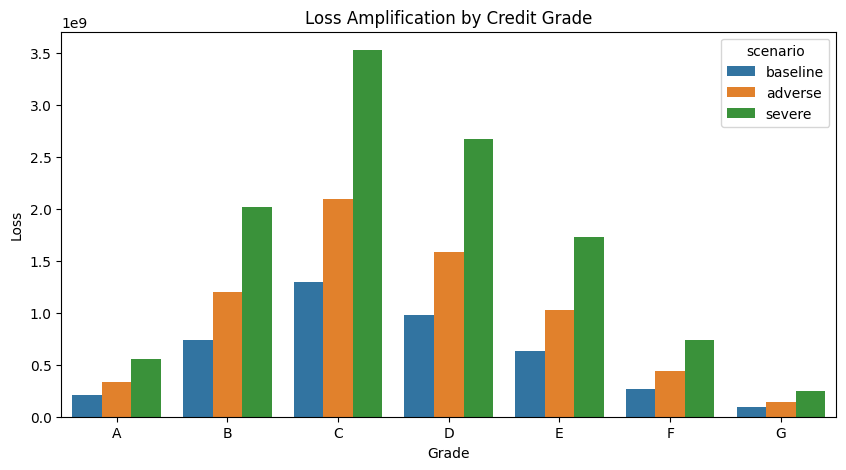

In [12]:
plt.figure(figsize=(10,5))
sns.barplot(
    data=grade_stress_df,
    x="grade",
    y="stressed_loss",
    hue="scenario"
)
plt.title("Loss Amplification by Credit Grade")
plt.ylabel("Loss")
plt.xlabel("Grade")
plt.show()

In [14]:
grade_delta = grade_stress_table.copy()

for scenario in ["adverse", "severe"]:
    grade_delta[f"{scenario}_loss_increase"] = (
        grade_delta[scenario] - grade_delta["baseline"]
    )

grade_delta

scenario,grade,adverse,baseline,severe,adverse_loss_increase,severe_loss_increase
0,A,331892009.4725,204962708.5447,558334445.5213,126929300.9278,353371736.9766
1,B,1200822304.6535,741577938.0584,2020116292.3563,459244366.5951,1278538354.2979
2,C,2099541568.3397,1296589596.2155,3532011449.3595,802951972.1242,2235421853.1440
3,D,1589717850.0064,981743660.7680,2674346501.2288,607974189.2384,1692602840.4608
4,E,1029271994.5642,635635597.7668,1731521073.0409,393636396.7973,1095885475.2741
5,F,436964140.6371,269850888.9812,735094923.0838,167113251.6560,465244034.1026
6,G,144653182.0691,89331792.1200,243346787.2028,55321389.9491,154014995.0828


In [16]:
grade_share = grade_stress_df.copy()

grade_share["loss_share"] = (
    grade_share["stressed_loss"] /
    grade_share.groupby("scenario")["stressed_loss"].transform("sum")
)

grade_share.query("scenario != 'baseline'")

,grade,loss,scenario,stressed_loss,loss_share
0,A,204962708.5447,adverse,331892009.4725,0.0486
1,B,741577938.0584,adverse,1200822304.6535,0.1757
2,C,1296589596.2155,adverse,2099541568.3397,0.3073
3,D,981743660.7680,adverse,1589717850.0064,0.2327
4,E,635635597.7668,adverse,1029271994.5642,0.1506
5,F,269850888.9812,adverse,436964140.6371,0.0640
6,G,89331792.1200,adverse,144653182.0691,0.0212
0,A,204962708.5447,severe,558334445.5213,0.0486
1,B,741577938.0584,severe,2020116292.3563,0.1757
2,C,1296589596.2155,severe,3532011449.3595,0.3073


Stress amplifies losses but does not change who contributes the most — that is driven by baseline portfolio composition.

In [17]:
results["incremental_loss"] = (
    results["stressed_loss"] - baseline_loss
)

results

,scenario,stress_multiplier,stressed_loss,loss_increase_pct,incremental_loss
0,baseline,1.0000,4219692182.4546,0.0000,0.0000
1,adverse,1.6193,6832863049.7425,61.9280,2613170867.2879
2,severe,2.7241,11494771471.7935,172.4078,7275079289.3388


In [23]:
GRADE_MULTIPLIER = {
    "A": 0.7,
    "B": 0.85,
    "C": 1.0,
    "D": 1.15,
    "E": 1.3,
    "F": 1.45,
    "G": 1.6
}

grade_stress_df["grade_multiplier"] = (
    grade_stress_df["grade"].map(GRADE_MULTIPLIER)
)

grade_stress_df["stressed_loss_adj"] = (
    grade_stress_df["stressed_loss"] *
    grade_stress_df["grade_multiplier"]
)
grade_stress_df.head()

,grade,loss,scenario,stressed_loss,grade_multiplier,stressed_loss_adj
0,A,204962708.5447,baseline,204962708.5447,0.7000,143473895.9813
1,B,741577938.0584,baseline,741577938.0584,0.8500,630341247.3497
2,C,1296589596.2155,baseline,1296589596.2155,1.0000,1296589596.2155
3,D,981743660.7680,baseline,981743660.7680,1.1500,1129005209.8832
4,E,635635597.7668,baseline,635635597.7668,1.3000,826326277.0969


In [22]:
results.to_csv("data/processed/portfolio_stress_results.csv", index=False)
grade_stress_df.to_csv("data/processed/grade_stress_results.csv", index=False)

### Key Takeaways

Portfolio losses exhibit strong non-linear amplification under macroeconomic
stress, with severe scenarios resulting in more than a 2.7× increase relative
to baseline. Losses are disproportionately concentrated in lower credit grades,
highlighting the importance of portfolio composition in stress resilience.
This framework demonstrates how transparent, scenario-driven stress testing
can provide actionable insights even without complex predictive models.